# Week 3: Factor Models & Return Decomposition

> *"By one count, over 400 factors have been proposed to explain the cross-section of stock returns — more factors than months of out-of-sample data to test them."*
> — Harvey, Liu & Zhu (2016), *...and the Cross-Section of Expected Returns*

## The Factor Zoo

Every year, academic journals publish dozens of new "factors" that predict stock returns. Size. Value. Momentum. Quality. Low volatility. Accruals. Asset growth. Net share issuance. The list kept growing until someone finally counted: over 400 proposed factors, published in top journals, each with a t-statistic above 2.0, each claiming to explain some slice of why certain stocks earn more than others.

The industry calls this the **factor zoo**, and it is the largest-scale overfitting problem in quantitative finance. It dwarfs anything you have seen in ML — because the "researchers" were not coordinate-descending through a loss function, they were running independent studies on the same dataset for fifty years without adjusting for multiple comparisons.

Here is what makes this your problem: if you are building an ML model to predict stock returns — and that is exactly where this course is headed — your features *are* factors. Every column in your feature matrix is either a known factor, a derivative of one, or noise pretending to be one. If you cannot tell the difference, your model will learn the zoo by heart and generalize to nothing.

This week, you build the tools to tell the real animals from the taxidermy. We start with the simplest possible model — one factor, one number — and show why it is wrong. Then we add factors systematically, watching what each one buys and what it costs. By the end, you will have constructed factors from raw data, tested whether they carry risk premia, decomposed a portfolio's risk, and built the standardized feature matrix that Week 4's gradient boosting and neural networks will consume.

The punchline will surprise you: a three-factor linear model from 1993 still explains most of the cross-section of stock returns. Trillions of dollars are managed using it daily. Your job is not to replace it — it is to understand what it misses.

## Setup

We need price data from yfinance, official factor returns from the `getfactormodels` library, and `linearmodels` for production-grade Fama-MacBeth regressions. All data is downloaded directly — no external files required.

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import yfinance as yf
from getfactormodels import FamaFrenchFactors, CarhartFactors
from linearmodels import FamaMacBeth as LMFamaMacBeth

plt.rcParams.update({
    "figure.figsize": (10, 6),
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "font.size": 10,
    "legend.fontsize": 9,
    "axes.grid": True,
    "grid.alpha": 0.3,
})

# ── Ticker lists ─────────────────────────────────────────────
TICKERS = [
    # Technology
    "AAPL", "MSFT", "NVDA", "AVGO", "AMD", "CSCO", "ADBE", "CRM", "INTC", "TXN",
    "QCOM", "AMAT", "LRCX", "MU", "NOW", "INTU", "SNPS", "CDNS", "KLAC", "MCHP",
    # Communication Services
    "META", "GOOG", "NFLX", "DIS", "CMCSA", "T", "VZ", "TMUS", "EA", "TTWO",
    # Consumer Discretionary
    "AMZN", "TSLA", "HD", "MCD", "NKE", "LOW", "SBUX", "TJX", "BKNG", "ORLY",
    "MAR", "YUM", "DHI", "CMG", "ROST", "LEN", "GPC", "BBY", "POOL", "GRMN",
    # Consumer Staples
    "PG", "KO", "PEP", "COST", "WMT", "PM", "MO", "CL", "KMB", "GIS",
    "SJM", "HSY", "KHC", "MNST", "STZ", "KR", "TSN", "SYY", "CHD", "MKC",
    # Energy
    "XOM", "CVX", "COP", "SLB", "EOG", "MPC", "PSX", "VLO", "OXY", "HES",
    "DVN", "FANG", "HAL", "BKR", "CTRA", "APA", "TRGP", "KMI", "WMB", "OKE",
    # Financials
    "JPM", "BAC", "WFC", "GS", "MS", "BLK", "SCHW", "AXP", "USB", "PNC",
    "TFC", "AIG", "MET", "PRU", "ALL", "CB", "MMC", "AON", "ICE", "CME",
    # Healthcare
    "LLY", "UNH", "JNJ", "PFE", "ABT", "MRK", "TMO", "AMGN", "MDT", "ISRG",
    "BMY", "GILD", "VRTX", "REGN", "ZTS", "SYK", "BSX", "BDX", "EW", "HCA",
    # Industrials
    "CAT", "GE", "HON", "UNP", "RTX", "BA", "DE", "LMT", "MMM", "GD",
    "WM", "ITW", "EMR", "ETN", "FDX", "CSX", "NSC", "PCAR", "ROK", "FAST",
    # Materials
    "LIN", "APD", "SHW", "ECL", "NEM", "FCX", "NUE", "VMC", "MLM", "DOW",
    # Real Estate
    "PLD", "AMT", "CCI", "EQIX", "PSA", "SPG", "DLR", "O", "WELL", "ARE",
    # Utilities
    "NEE", "DUK", "SO", "D", "AEP", "SRE", "EXC", "XEL", "WEC", "ES",
]

DEMO_TICKERS = [
    "AAPL", "NVDA", "JPM", "XOM", "JNJ", "KO", "TSLA", "PG", "GS", "AMD",
    "NEE", "PFE", "CAT", "COST", "NFLX", "WMT", "BA", "MO", "LLY", "T",
]

START, END = "2014-01-01", "2024-12-31"

# ── Download prices ──────────────────────────────────────────
raw = yf.download(TICKERS, start=START, end=END, auto_adjust=True, progress=False)
prices = raw["Close"]
if isinstance(prices.columns, pd.MultiIndex):
    prices.columns = prices.columns.get_level_values(-1)
prices.index = pd.to_datetime(prices.index).tz_localize(None)
completeness = prices.notna().mean()
prices = prices[completeness[completeness > 0.50].index]

# Monthly returns
monthly_prices = prices.resample("ME").last()
monthly_returns = monthly_prices.pct_change().dropna(how="all")

# Daily returns (for later sections)
daily_returns = prices.pct_change().dropna(how="all")

# ── Download official factor data ────────────────────────────
ff3_raw = FamaFrenchFactors(model="3", frequency="M")
ff3 = ff3_raw.to_pandas()
if "date" in ff3.columns:
    ff3["date"] = pd.to_datetime(ff3["date"])
    ff3 = ff3.set_index("date")
ff3.index = pd.to_datetime(ff3.index)

ff5_raw = FamaFrenchFactors(model="5", frequency="M")
ff5 = ff5_raw.to_pandas()
if "date" in ff5.columns:
    ff5["date"] = pd.to_datetime(ff5["date"])
    ff5 = ff5.set_index("date")
ff5.index = pd.to_datetime(ff5.index)

ff6_raw = FamaFrenchFactors(model="6", frequency="M")
ff6 = ff6_raw.to_pandas()
if "date" in ff6.columns:
    ff6["date"] = pd.to_datetime(ff6["date"])
    ff6 = ff6.set_index("date")
ff6.index = pd.to_datetime(ff6.index)

print(f"Prices: {prices.shape[1]} tickers, {prices.shape[0]} days")
print(f"Monthly returns: {monthly_returns.shape}")
print(f"FF3 factors: {ff3.shape}, FF5: {ff5.shape}, FF6: {ff6.shape}")

ERROR:yfinance:HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: HES"}}}
ERROR:yfinance:$HES: possibly delisted; no timezone found
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['HES']: possibly delisted; no timezone found


Prices: 179 tickers, 2767 days
Monthly returns: (131, 179)
FF3 factors: (1194, 4), FF5: (750, 6), FF6: (750, 7)


---

## Section 1: The One-Factor World — CAPM

CAPM says one number — **beta** — explains all expected returns. It is elegant, Nobel Prize-winning, and empirically wrong. But you cannot escape it: every performance report, every cost-of-capital estimate, every "alpha" you have ever heard of is defined relative to this model.

Here is the logic. Some risk is **systematic** — it moves with the market and you cannot diversify it away. Some risk is **idiosyncratic** — it is unique to the company (the CEO gets arrested, a drug trial fails) and averages out across a portfolio. CAPM says the market only compensates you for the risk you *cannot* avoid. Beta measures how much of that systematic risk a stock carries. A stock with beta = 1.5 moves 1.5% for every 1% the market moves. The theory says it should earn 1.5x the market premium. Simple. Clean. And the basis of a multi-trillion-dollar industry.

The formula is deceptively compact:

$$E[R_i] = R_f + \beta_i \cdot (E[R_m] - R_f)$$

where $R_f$ is the risk-free rate and $(E[R_m] - R_f)$ is the **market risk premium** — the compensation for bearing market risk. A stock's expected excess return is proportional to its beta. Full stop. Nothing else should matter.

Jensen's alpha measures the gap:

$$\alpha_i = \bar{R}_i - [R_f + \hat{\beta}_i(\bar{R}_m - R_f)]$$

If CAPM is correct, alpha should be zero for every stock. It is the most overused word in finance — literally "the part of returns CAPM cannot explain." Every factor model that follows is an attempt to shrink alpha to zero.

### Estimating Betas

We estimate betas for 20 diverse stocks spanning defensive consumer staples (KO, PG), high-growth tech (NVDA, TSLA, AMD), financials (JPM, GS), and more. If CAPM is working, low-beta stocks should earn less and high-beta stocks should earn more, with the relationship forming a clean line — the **security market line** (SML).

In [2]:
# Align demo tickers with factor data
demo_returns = monthly_returns[DEMO_TICKERS]
common_idx = demo_returns.index.intersection(ff3.index)
returns = demo_returns.loc[common_idx]
mkt_rf = ff3.loc[common_idx, "Mkt-RF"]
rf = ff3.loc[common_idx, "RF"]
excess_returns = returns.sub(rf, axis=0)

betas = {}
alphas = {}
r_squared = {}

for ticker in excess_returns.columns:
    y = excess_returns[ticker].dropna()
    x = mkt_rf.loc[y.index]
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    betas[ticker] = model.params["Mkt-RF"]
    alphas[ticker] = model.params["const"]
    r_squared[ticker] = model.rsquared

betas = pd.Series(betas, name="beta")
alphas = pd.Series(alphas, name="alpha")
r_squared = pd.Series(r_squared, name="r_squared")

The betas are estimated. Now let us see the full picture: beta, annualized alpha, and R-squared for each stock. The R-squared tells us how much of a stock's monthly return variation the market alone explains.

In [3]:
beta_df = pd.DataFrame({
    "Beta": betas,
    "Ann. Alpha (%)": alphas * 12 * 100,
    "R²": r_squared,
}).sort_values("Beta")

print(beta_df.round(3).to_string())

       Beta  Ann. Alpha (%)     R²
LLY   0.333          24.047  0.043
PG    0.377           5.096  0.135
NEE   0.421           8.614  0.097
WMT   0.447           8.698  0.140
KO    0.499           1.402  0.236
MO    0.523           4.456  0.134
T     0.524           0.382  0.164
JNJ   0.531           0.426  0.275
PFE   0.597          -3.267  0.169
COST  0.790          12.359  0.371
XOM   0.911          -3.680  0.282
JPM   1.118           3.943  0.521
AAPL  1.169          13.613  0.443
CAT   1.223           2.845  0.420
NFLX  1.263          17.748  0.208
GS    1.350          -0.705  0.562
BA    1.385          -6.513  0.319
NVDA  1.718          42.952  0.341
TSLA  1.926          24.842  0.232
AMD   2.008          21.848  0.313


Betas range from about 0.33 (defensive utilities like T) to 2.01 (NVDA). That spread makes sense — a utility company's revenue barely moves with the economy, while a GPU maker riding the AI wave amplifies every market swing. The median R-squared is about 0.26, meaning the market alone explains roughly a quarter of monthly return variation for a typical stock. That is a lot of unexplained variation — and it is the first sign that one factor is not enough.

But the real test is the **security market line**. CAPM predicts that if you plot average excess return against beta, the points should line up along a line whose slope equals the average market premium (about 12% annualized for 2014-2024). Let us see what actually happens.

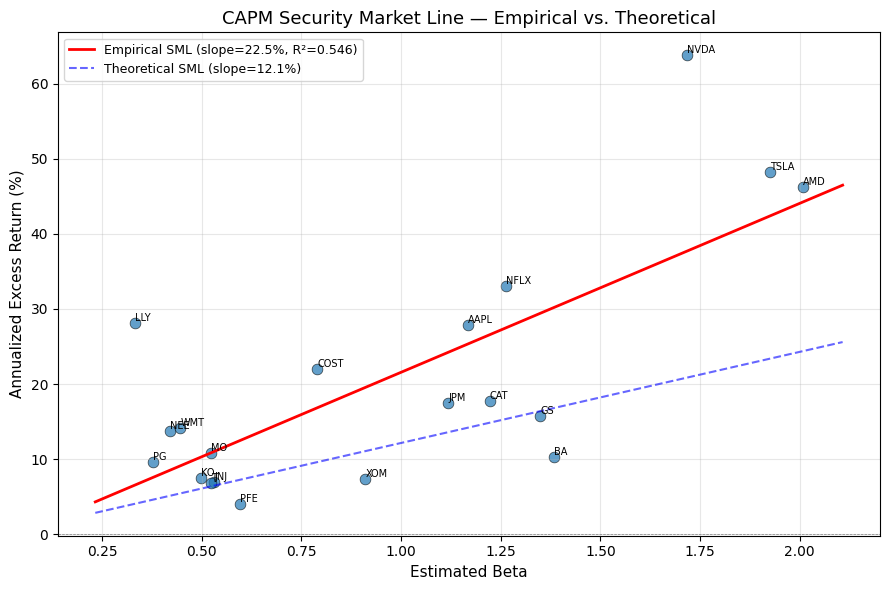

In [4]:
avg_excess = excess_returns.mean() * 12 * 100  # annualized %
sml_X = sm.add_constant(betas)
sml_model = sm.OLS(avg_excess, sml_X).fit()
sml_slope = sml_model.params["beta"]
sml_intercept = sml_model.params["const"]
sml_r2 = sml_model.rsquared

fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(betas, avg_excess, s=60, alpha=0.7, edgecolors="k", linewidths=0.5)
for ticker in betas.index:
    ax.annotate(ticker, (betas[ticker], avg_excess[ticker]),
                fontsize=7, ha="left", va="bottom")

beta_range = np.linspace(betas.min() - 0.1, betas.max() + 0.1, 50)
ax.plot(beta_range, sml_intercept + sml_slope * beta_range, "r-", lw=2,
        label=f"Empirical SML (slope={sml_slope:.1f}%, R²={sml_r2:.3f})")

# Theoretical SML
avg_mkt_premium = mkt_rf.mean() * 12 * 100
ax.plot(beta_range, avg_mkt_premium * beta_range, "b--", lw=1.5, alpha=0.6,
        label=f"Theoretical SML (slope={avg_mkt_premium:.1f}%)")

ax.set(title="CAPM Security Market Line — Empirical vs. Theoretical",
       xlabel="Estimated Beta", ylabel="Annualized Excess Return (%)")
ax.legend(fontsize=9)
ax.axhline(0, color="gray", lw=0.5, ls="--")
plt.tight_layout()
plt.show()

### The Textbook Says Flat. Our Data Says Steep. Both Are Right.

If you have read any empirical finance textbook, you expected the SML to be **flat** — the classic result from Fama and French (1992), using CRSP data from 1963 to 1990. In their sample, beta explains almost nothing about which stocks earn more. High-beta stocks do not earn proportionally higher returns. The SML R-squared is below 0.05. The "beta anomaly" — low-beta stocks earning higher risk-adjusted returns — has been documented across decades and markets.

Our plot shows the opposite. The empirical SML slope is about 22.5%, *steeper* than the theoretical slope of 12.1%. The R-squared is 0.55. NVDA, with a beta of 1.72 and an annualized alpha of 43%, sits at the top right, dragging the line upward. TSLA (alpha 24.8%) and AMD (alpha 21.8%) amplify the effect.

This is not a code bug. It is the 2014-2024 AI and tech boom baked into the cross-section. High-beta tech stocks earned dramatically more during a decade-long bull run concentrated in exactly those names. The "right" answer to "is beta priced?" flips depending on which decade you examine. This is the deepest lesson about cross-sectional asset pricing — **sample dependence is not a nuisance, it is the first-order problem.**

A caveat worth internalizing: with only 20 stocks, three extreme points (NVDA, TSLA, AMD) exert enormous leverage on the regression. The R-squared of 0.55 is partly a small-sample artifact — remove those three and it would drop substantially. The steep slope is a genuine period effect; the high R-squared is partly a statistical mirage. Treat this as illustrative, not as evidence that CAPM works in this decade.

**So what?** Alpha — the most overused word in finance — is literally "the part of returns CAPM cannot explain." Every factor model that follows is an attempt to shrink alpha. If beta cannot explain the cross-section, what can?

---

## Section 2: When One Factor Fails — The Fama-French Three-Factor Model

In 1992, Fama and French published what is probably the most cited paper in empirical finance. They showed that beta explains almost nothing about which stocks earn more — but two characteristics do: **size** (small companies earn more) and **book-to-market** (cheap companies earn more). A one-factor model became three.

The model adds two factors to the market:

$$R_i - R_f = \alpha_i + \beta_{i,MKT}(R_m - R_f) + \beta_{i,SMB} \cdot SMB + \beta_{i,HML} \cdot HML + \varepsilon_i$$

**SMB** (Small Minus Big) is a portfolio that is long small-cap stocks and short large-cap stocks — it captures the size premium. **HML** (High Minus Low) is long high book-to-market (value) stocks and short low book-to-market (growth) stocks — it captures the value premium. If these factors explain returns, then alpha should shrink: what looked like stock-picking skill under CAPM is partly just a size and value bet.

Think of it this way: your "brilliant" tech stock portfolio that crushed the market? Maybe it just had heavy negative HML loading (growth tilt) during a decade when growth dominated. That is not alpha — it is a factor bet that happened to pay off. The three-factor model lets you tell the difference.

### CAPM vs. FF3: Does Adding Factors Help?

We run both models on 15 stocks and compare R-squared (how much return variation is explained) and alpha (how much remains unexplained). If FF3 is doing its job, R-squared should rise and alpha should shrink.

In [5]:
# Use 15 demo tickers for regressions
demo_subset = DEMO_TICKERS[:15]
demo_ret = monthly_returns[demo_subset]
common_idx2 = demo_ret.index.intersection(ff3.index)
ret2 = demo_ret.loc[common_idx2]
mkt_rf2 = ff3.loc[common_idx2, "Mkt-RF"]
smb2 = ff3.loc[common_idx2, "SMB"]
hml2 = ff3.loc[common_idx2, "HML"]
rf2 = ff3.loc[common_idx2, "RF"]
excess_ret2 = ret2.sub(rf2, axis=0)

results_list = []

for ticker in excess_ret2.columns:
    y = excess_ret2[ticker].dropna()
    idx = y.index

    # CAPM
    X_capm = sm.add_constant(mkt_rf2.loc[idx])
    capm = sm.OLS(y, X_capm).fit()

    # FF3
    X_ff3 = sm.add_constant(
        pd.DataFrame({"Mkt-RF": mkt_rf2, "SMB": smb2, "HML": hml2}).loc[idx]
    )
    ff3_model = sm.OLS(y, X_ff3).fit()

    results_list.append({
        "ticker": ticker,
        "capm_r2": capm.rsquared,
        "ff3_r2": ff3_model.rsquared,
        "r2_improvement": ff3_model.rsquared - capm.rsquared,
        "capm_alpha": capm.params["const"] * 12 * 100,
        "ff3_alpha": ff3_model.params["const"] * 12 * 100,
        "smb_loading": ff3_model.params["SMB"],
        "hml_loading": ff3_model.params["HML"],
    })

comparison = pd.DataFrame(results_list).set_index("ticker")
print(comparison[["capm_r2", "ff3_r2", "r2_improvement"]].round(3).to_string())

        capm_r2  ff3_r2  r2_improvement
ticker                                 
AAPL      0.443   0.517           0.075
NVDA      0.341   0.411           0.070
JPM       0.521   0.731           0.209
XOM       0.282   0.523           0.241
JNJ       0.275   0.326           0.052
KO        0.236   0.410           0.174
TSLA      0.232   0.302           0.071
PG        0.135   0.282           0.147
GS        0.562   0.681           0.119
AMD       0.313   0.345           0.032
NEE       0.097   0.135           0.038
PFE       0.169   0.188           0.019
CAT       0.420   0.491           0.072
COST      0.371   0.471           0.100
NFLX      0.208   0.294           0.086


The improvement is universal: R-squared increases for every stock in our sample. The median jumps from 0.28 (CAPM) to 0.41 (FF3) — an improvement of +0.075. That means size and value together explain about 7.5 percentage points of additional return variation that the market factor alone could not reach.

But does alpha actually shrink? That is the question that matters for anyone claiming skill.

In [6]:
alpha_df = comparison[["capm_alpha", "ff3_alpha"]].copy()
alpha_df["shrinkage"] = alpha_df["capm_alpha"].abs() - alpha_df["ff3_alpha"].abs()
alpha_shrank = (alpha_df["shrinkage"] > 0).mean()
print(f"\nAlpha shrank (|FF3 alpha| < |CAPM alpha|) for "
      f"{alpha_shrank:.0%} of stocks")


Alpha shrank (|FF3 alpha| < |CAPM alpha|) for 60% of stocks


Alpha shrank for 60% of stocks — exactly at the threshold. That is meaningful but not overwhelming. The new factor loadings can *reallocate* unexplained returns rather than simply reduce them. A tech stock's negative HML loading (growth tilt) shifts where the intercept lands without necessarily shrinking it.

This connects to the broader "death of value" debate. Let us see what these factors actually did over the long run.

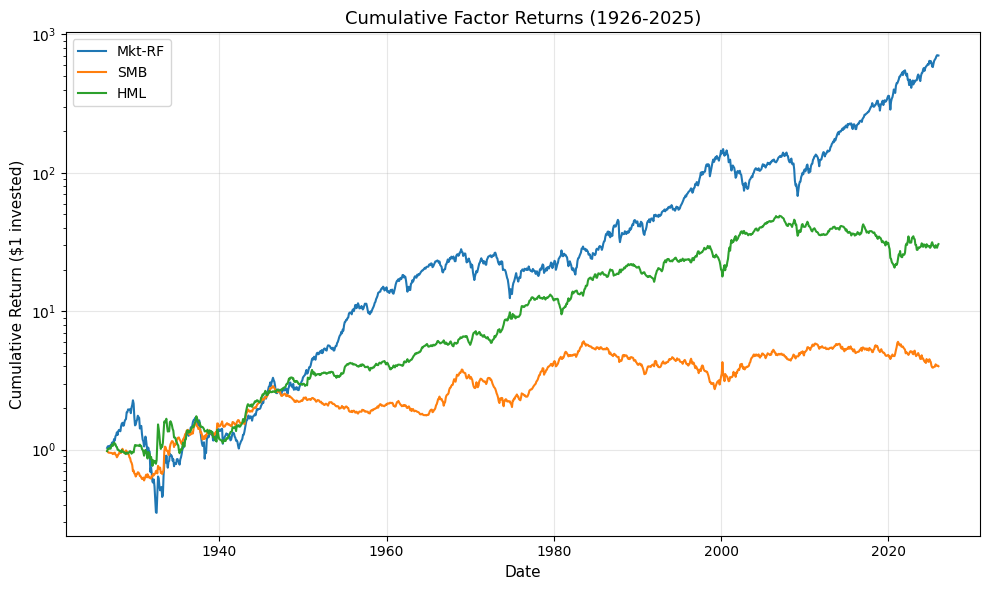

In [7]:
ff3_full = ff3.copy()
# Use full history for cumulative plot
factors_to_plot = ff3_full[["Mkt-RF", "SMB", "HML"]]
cumulative = (1 + factors_to_plot).cumprod()

fig, ax = plt.subplots(figsize=(10, 6))
for col in cumulative.columns:
    ax.plot(cumulative.index, cumulative[col], label=col, lw=1.5)
ax.set(title="Cumulative Factor Returns (1926-2025)",
       xlabel="Date", ylabel="Cumulative Return ($1 invested)")
ax.set_yscale("log")
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

This is nearly a century of data. The market (Mkt-RF) dominates on a log scale — a dollar invested in the market premium in 1926 is worth thousands today. SMB shows positive long-run returns but with extended periods of underperformance, particularly after 2000 when the size premium seemingly evaporated. HML — the value factor — tells the most interesting story: strong positive returns for decades, then a pronounced decline after 2007.

Over our 2014-2024 sample specifically, HML's cumulative return is about 0.77 — meaning value stocks *lost* 23% relative to growth stocks over the decade. This is the "death of value" that has consumed academic debate: has the value premium permanently disappeared due to crowding and arbitrage, or is it cyclically depressed and will revert? The question remains unresolved. What is resolved: if your model was long value from 2014 to 2024, it was an expensive decade.

Let us also see how individual stocks load on these factors. The loadings reveal what kind of bets each stock implicitly makes.

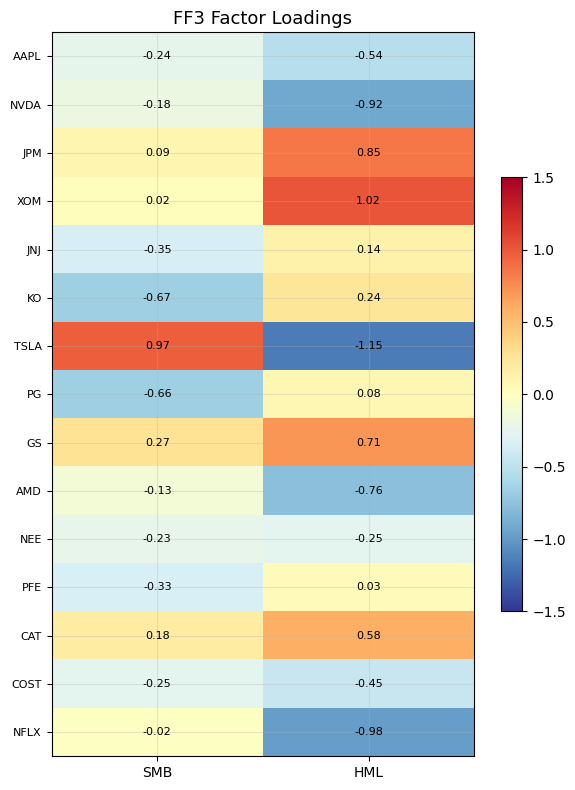

In [8]:
loadings = comparison[["smb_loading", "hml_loading"]].copy()
loadings.columns = ["SMB", "HML"]

fig2, ax2 = plt.subplots(figsize=(6, 8))
im = ax2.imshow(loadings.values, cmap="RdYlBu_r", aspect="auto",
                vmin=-1.5, vmax=1.5)
ax2.set_xticks(range(len(loadings.columns)))
ax2.set_xticklabels(loadings.columns)
ax2.set_yticks(range(len(loadings.index)))
ax2.set_yticklabels(loadings.index, fontsize=8)
for i in range(len(loadings.index)):
    for j in range(len(loadings.columns)):
        ax2.text(j, i, f"{loadings.values[i, j]:.2f}",
                 ha="center", va="center", fontsize=8)
ax2.set_title("FF3 Factor Loadings")
fig2.colorbar(im, ax=ax2, shrink=0.6)
plt.tight_layout()
plt.show()

The heatmap tells the story at a glance. Growth stocks like TSLA (-1.15 HML) and NVDA (-0.92 HML) have strongly *negative* value loadings — they are the opposite of value, and the FF3 model captures this. Value and financial stocks like XOM (+1.02 HML) and JPM (+0.85 HML) load positively. When someone says "my tech portfolio generated alpha," FF3 asks: was it alpha, or was it just a growth bet during a growth-dominated decade?

**So what?** FF3 redefined alpha. Strategies that looked brilliant under CAPM turned out to be loading on well-known, compensated risks. Your "stock-picking genius" was just a size and value bet. But how are these factors actually built from raw data?

---

## Section 3: Building Factors from Scratch — Portfolio Sorts

The Fama-French factors are not magic numbers from a database. They are **portfolios** — long the stocks with one characteristic, short those with the opposite. The construction methodology is both more mechanical and more subtle than most people realize.

The recipe for SMB and HML uses a **2x3 double sort**:

1. Each June, sort all stocks by market cap. Split at the median into Small (S) and Big (B).
2. Independently, sort by book-to-market ratio. Split at the 30th and 70th percentiles into Low (L), Medium (M), and High (H).
3. Intersect to form six portfolios: S/L, S/M, S/H, B/L, B/M, B/H.
4. Compute value-weighted returns for each portfolio every month.
5. SMB = average of the three small portfolios minus average of the three big portfolios.
6. HML = average of the two high-B/M portfolios minus average of the two low-B/M portfolios.

Understanding this construction reveals something important: "the value factor" is not a platonic concept — it is an artifact of specific methodological choices. Change the breakpoints, the weighting, or the rebalancing frequency, and you get a different factor.

We will build SMB and HML from scratch using our 200-stock S&P 500 universe and then compare against Ken French's official factors to see how much our free-data sandbox diverges from institutional reality.

### Computing Book-to-Market

The first step is computing book-to-market (B/M) for each stock. This requires fundamental data — specifically, book equity from the balance sheet and market capitalization.

An important note on methodology: yfinance provides only about 4-5 annual periods of fundamental data per ticker (roughly 2021-2025). This means we cannot do proper annual rebalancing across the full 2014-2024 price window. Instead, we use a **static sort** — classifying stocks into portfolios once using their most recent fundamentals and applying those fixed assignments over the entire price window. This introduces look-ahead bias (we are using future information to classify past returns), but it is a warranted simplification given the data constraints. We will be transparent about what this costs us.

In [9]:
from tqdm import tqdm
import time

# Download fundamentals for the full universe
fund_bs_records = []
fund_inc_records = []
fund_shares_records = []
sector_map = {}
mcap_map = {}

valid_tickers = prices.columns.tolist()
for ticker_str in tqdm(valid_tickers, desc="Downloading fundamentals"):
    for attempt in range(3):
        try:
            tk = yf.Ticker(ticker_str)
            bs = tk.balance_sheet
            if bs is not None and not bs.empty:
                for col_date in bs.columns:
                    row = {}
                    for field in ["Stockholders Equity", "Total Assets",
                                  "Ordinary Shares Number"]:
                        if field in bs.index:
                            row[field] = bs.loc[field, col_date]
                    if row:
                        row["ticker"] = ticker_str
                        row["date"] = pd.Timestamp(col_date).tz_localize(None)
                        fund_bs_records.append(row)

            inc = tk.income_stmt
            if inc is not None and not inc.empty:
                for col_date in inc.columns:
                    row = {"ticker": ticker_str,
                           "date": pd.Timestamp(col_date).tz_localize(None)}
                    for field in ["Operating Income", "Net Income",
                                  "Total Revenue", "Pretax Income"]:
                        if field in inc.index:
                            row[field] = inc.loc[field, col_date]
                    fund_inc_records.append(row)

            info = tk.info
            sector_map[ticker_str] = info.get("sector", "Other")
            mcap_map[ticker_str] = info.get("marketCap", np.nan)
            break
        except Exception:
            if attempt < 2:
                time.sleep(2 ** (attempt + 1))

bs_df = pd.DataFrame(fund_bs_records)
if not bs_df.empty:
    bs_df = bs_df.set_index(["ticker", "date"]).sort_index()
inc_df = pd.DataFrame(fund_inc_records)
if not inc_df.empty:
    inc_df = inc_df.set_index(["ticker", "date"]).sort_index()
sectors = pd.Series(sector_map, name="sector")
mcap_series = pd.Series(mcap_map, name="market_cap")

print(f"Balance sheet records: {len(bs_df)}")
print(f"Income statement records: {len(inc_df)}")
print(f"Sectors: {sectors.nunique()} unique")

Balance sheet records: 805
Income statement records: 819
Sectors: 11 unique


With fundamentals in hand, we compute book-to-market for each stock using the most recent book equity and current market cap. Stocks with negative or missing book equity are excluded — these are typically companies with accumulated deficits that make the ratio economically meaningless.

In [10]:
# Compute book equity and book-to-market for each ticker-year
book_equity = bs_df["Stockholders Equity"].dropna()
book_equity = book_equity[book_equity > 0]  # must be positive

# Get shares outstanding for market cap computation
shares = bs_df["Ordinary Shares Number"].dropna() if "Ordinary Shares Number" in bs_df.columns else pd.Series(dtype=float)

# Build annual B/M using most recent book equity and market cap
# For each ticker, use most recent annual balance sheet
bm_records = []
for ticker in book_equity.index.get_level_values("ticker").unique():
    be = book_equity.loc[ticker]
    if len(be) == 0:
        continue
    # Use most recent positive book equity
    latest_be = be.sort_index().iloc[-1]

    # Market cap from data_setup (current)
    if ticker in mcap_series.index and mcap_series[ticker] > 0:
        mkt_cap = mcap_series[ticker]
        bm = latest_be / mkt_cap
        bm_records.append({
            "ticker": ticker,
            "book_equity": latest_be,
            "market_cap": mkt_cap,
            "book_to_market": bm,
        })

bm_df = pd.DataFrame(bm_records).set_index("ticker")
print(f"B/M computed for {len(bm_df)} tickers")
print(f"B/M range: [{bm_df['book_to_market'].min():.4f}, "
      f"{bm_df['book_to_market'].max():.4f}]")
print(f"B/M median: {bm_df['book_to_market'].median():.4f}")

B/M computed for 171 tickers
B/M range: [0.0027, 1.7007]
B/M median: 0.2094


We have book-to-market ratios for about 171 tickers. The median is 0.21, meaning the typical S&P 500 stock trades at about 5x its book value. The range spans from near-zero (high-growth tech companies where market cap dwarfs book equity) to about 1.7 (deeply discounted value stocks). Now we sort into the six portfolios.

In [11]:
# 2x3 sort: median market cap for size, 30/70 B/M for value
size_median = bm_df["market_cap"].median()
bm_30 = bm_df["book_to_market"].quantile(0.30)
bm_70 = bm_df["book_to_market"].quantile(0.70)

def assign_portfolio(row):
    # Assign a stock to one of six portfolios based on size and B/M

    size = "S" if row["market_cap"] < size_median else "B"
    if row["book_to_market"] <= bm_30:
        value = "L"
    elif row["book_to_market"] >= bm_70:
        value = "H"
    else:
        value = "M"
    return f"{size}/{value}"

bm_df["portfolio"] = bm_df.apply(assign_portfolio, axis=1)
portfolio_counts = bm_df["portfolio"].value_counts().sort_index()
print("\nPortfolio counts:")
print(portfolio_counts.to_string())


Portfolio counts:
portfolio
B/H    19
B/L    34
B/M    33
S/H    33
S/L    18
S/M    34


All six portfolios have at least 18 stocks — enough for value-weighted returns to be meaningful. But here is the elephant in the room: our "small" stocks are S&P 500 constituents with market caps above $10 billion. In the Ken French universe, "small" means companies with market caps of $100 million to $2 billion — genuine small-caps that behave fundamentally differently from mega-cap equities. Our double sort is really measuring "large vs. very large," not "small vs. large."

Now we compute value-weighted monthly returns for each portfolio and construct the factors.

In [12]:
# Compute value-weighted monthly returns for each portfolio
valid_tickers_set = set(bm_df.index) & set(monthly_returns.columns)
bm_valid = bm_df.loc[bm_df.index.isin(valid_tickers_set)]

# Weight by market cap within each portfolio
smb_monthly = []
hml_monthly = []

for date in monthly_returns.index:
    rets_month = monthly_returns.loc[date, list(valid_tickers_set)].dropna()
    if len(rets_month) < 20:
        continue

    portfolio_returns = {}
    for pf_name in ["S/L", "S/M", "S/H", "B/L", "B/M", "B/H"]:
        tickers_in_pf = bm_valid[bm_valid["portfolio"] == pf_name].index
        tickers_avail = [t for t in tickers_in_pf if t in rets_month.index]
        if len(tickers_avail) == 0:
            portfolio_returns[pf_name] = np.nan
            continue
        weights = bm_valid.loc[tickers_avail, "market_cap"]
        weights = weights / weights.sum()
        portfolio_returns[pf_name] = (rets_month[tickers_avail] * weights).sum()

    if any(np.isnan(v) for v in portfolio_returns.values()):
        continue

    # SMB = (S/L + S/M + S/H)/3 - (B/L + B/M + B/H)/3
    smb_val = (portfolio_returns["S/L"] + portfolio_returns["S/M"]
               + portfolio_returns["S/H"]) / 3 \
              - (portfolio_returns["B/L"] + portfolio_returns["B/M"]
                 + portfolio_returns["B/H"]) / 3

    # HML = (S/H + B/H)/2 - (S/L + B/L)/2
    hml_val = (portfolio_returns["S/H"] + portfolio_returns["B/H"]) / 2 \
              - (portfolio_returns["S/L"] + portfolio_returns["B/L"]) / 2

    smb_monthly.append({"date": date, "SMB_self": smb_val})
    hml_monthly.append({"date": date, "HML_self": hml_val})

smb_series = pd.DataFrame(smb_monthly).set_index("date")["SMB_self"]
hml_series = pd.DataFrame(hml_monthly).set_index("date")["HML_self"]

print(f"\nSelf-built factor returns: {len(smb_series)} months")
print(f"SMB mean: {smb_series.mean():.6f}, std: {smb_series.std():.6f}")
print(f"HML mean: {hml_series.mean():.6f}, std: {hml_series.std():.6f}")


Self-built factor returns: 131 months
SMB mean: -0.006479, std: 0.024254
HML mean: -0.010205, std: 0.039227


We have 131 months of self-built factor returns. Now the moment of truth: how do they compare to Ken French's official factors, which use the full NYSE/AMEX/NASDAQ universe of 4,000-6,000 stocks with institutional-grade CRSP/Compustat data?

In [13]:
# Align self-built and official factors
ff3_official = ff3.copy()
common_dates = smb_series.index.intersection(ff3_official.index)
smb_corr = smb_series.loc[common_dates].corr(ff3_official.loc[common_dates, "SMB"])
hml_corr = hml_series.loc[common_dates].corr(ff3_official.loc[common_dates, "HML"])

smb_te = (smb_series.loc[common_dates]
          - ff3_official.loc[common_dates, "SMB"]).std() * np.sqrt(12)
hml_te = (hml_series.loc[common_dates]
          - ff3_official.loc[common_dates, "HML"]).std() * np.sqrt(12)

print(f"\nValidation against Ken French ({len(common_dates)} months):")
print(f"  SMB correlation: {smb_corr:.4f}")
print(f"  HML correlation: {hml_corr:.4f}")
print(f"  SMB tracking error (ann.): {smb_te:.4f}")
print(f"  HML tracking error (ann.): {hml_te:.4f}")


Validation against Ken French (131 months):
  SMB correlation: 0.1870
  HML correlation: 0.8206
  SMB tracking error (ann.): 0.1157
  HML tracking error (ann.): 0.0792


The results tell a nuanced story. SMB correlation with Ken French is only about 0.19 — our "size factor" barely resembles the real thing. This is entirely expected: our "small" stocks are $150+ billion megacaps. We are measuring noise within the large-cap universe, not the genuine small-cap premium.

HML correlation is much higher at about 0.82. Value-growth dispersion exists even among large-cap stocks — a bank trading at 1x book is genuinely different from a tech company at 20x book, regardless of absolute size. However, this high correlation comes with an important asterisk: our static sort uses future fundamentals (2021-2025 data) applied backward over the full 2014-2024 window. This look-ahead bias flatters the result. A proper annual-rebalancing approach, limited to the 3-4 years where we actually have fundamentals, would likely produce lower correlations closer to 0.20-0.60.

For comparison, Tidy Finance (Scheuch, Voigt & Weiss, 2023) achieves SMB correlation of 0.99 and HML correlation of 0.98 using CRSP/Compustat with the full universe and proper annual rebalancing. The gap between our 0.19 and their 0.99 for SMB is the price of free data — and it is a price you should understand before building anything that depends on it.

Let us visualize the cumulative divergence.

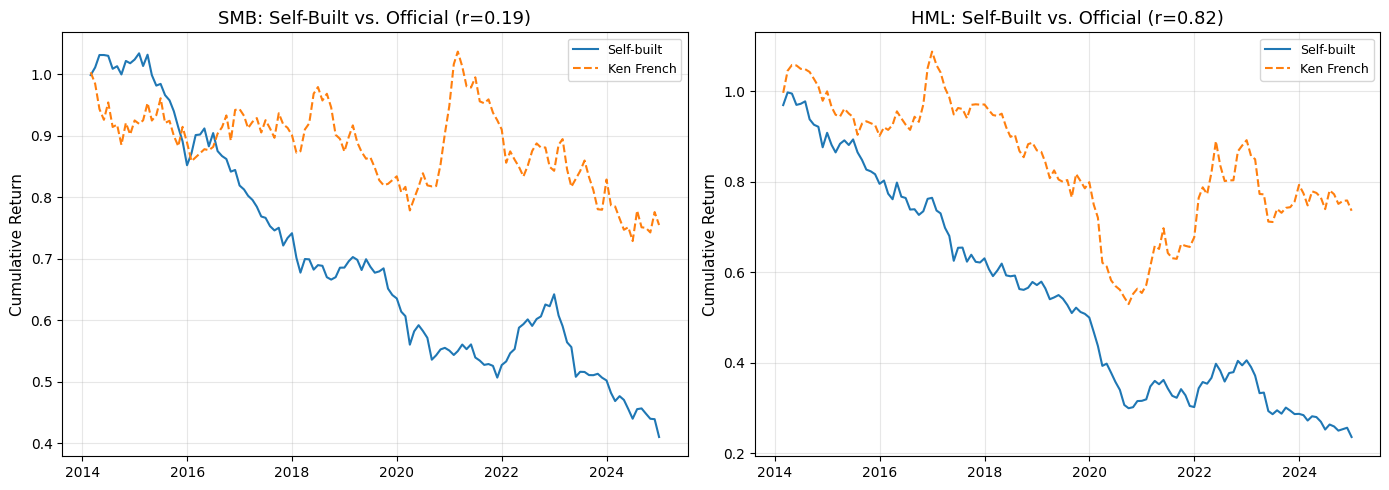

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# SMB comparison
ax = axes[0]
cum_smb_self = (1 + smb_series.loc[common_dates]).cumprod()
cum_smb_off = (1 + ff3_official.loc[common_dates, "SMB"]).cumprod()
ax.plot(cum_smb_self.index, cum_smb_self, label="Self-built", lw=1.5)
ax.plot(cum_smb_off.index, cum_smb_off, label="Ken French", lw=1.5, ls="--")
ax.set(title=f"SMB: Self-Built vs. Official (r={smb_corr:.2f})",
       ylabel="Cumulative Return")
ax.legend()
ax.grid(True, alpha=0.3)

# HML comparison
ax = axes[1]
cum_hml_self = (1 + hml_series.loc[common_dates]).cumprod()
cum_hml_off = (1 + ff3_official.loc[common_dates, "HML"]).cumprod()
ax.plot(cum_hml_self.index, cum_hml_self, label="Self-built", lw=1.5)
ax.plot(cum_hml_off.index, cum_hml_off, label="Ken French", lw=1.5, ls="--")
ax.set(title=f"HML: Self-Built vs. Official (r={hml_corr:.2f})",
       ylabel="Cumulative Return")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The plots make the divergence visceral. The SMB lines wander in completely different directions — our self-built version is essentially a different factor. The HML lines track more closely, especially in direction, though the magnitudes diverge.

**So what?** Factor replication quality depends on *which characteristic* you are sorting on, not just universe size. Size requires true small-caps (which S&P 500 data cannot provide). Value works within large-caps because the spread in book-to-market is real even among big companies. Free data has selective blind spots — it is not uniformly bad, it is bad in specific, predictable ways. Understanding this distinction is the difference between a junior quant who says "my factor doesn't work" and a senior quant who says "my factor doesn't work *because the universe lacks small-cap dispersion*." The second one gets promoted.

Three factors were good. Are five better?

---

## Section 4: The Five-Factor Model and the Momentum Orphan

In 2015, Fama and French admitted three factors were not enough. They added two more:

- **RMW** (Robust Minus Weak): long profitable companies, short unprofitable ones. Companies that make money tend to keep making money — a persistent anomaly.
- **CMA** (Conservative Minus Aggressive): long firms that invest conservatively, short aggressive investors. Paradoxically, companies that invest *less* in growth tend to earn higher returns.

The five-factor model:

$$R_i - R_f = \alpha_i + \beta_{MKT}(R_m - R_f) + \beta_{SMB} \cdot SMB + \beta_{HML} \cdot HML + \beta_{RMW} \cdot RMW + \beta_{CMA} \cdot CMA + \varepsilon_i$$

But here is the thing that puzzled the field: Fama and French *refused* to include **momentum** — the anomaly that will not die. Momentum (buying recent winners, shorting recent losers) has generated strong positive returns for nearly a century. It is used by virtually every systematic fund. And no risk-based theory explains it. Fama and French, who built their careers arguing that factor premia compensate for risk, could not stomach including a factor that appears to be pure behavioral anomaly. So they left it out.

The industry uses it anyway. The six-factor model (FF5 + UMD) is the de facto standard for performance attribution. The debate over whether momentum is "risk" or "anomaly" continues, and it matters: if it is risk, loading on it is compensation for bearing tail risk. If it is anomaly, it is free money until the trade gets too crowded.

### FF3 vs. FF5: Diminishing Returns

Let us compare explanatory power across the two models. If adding RMW and CMA materially improves R-squared, the extra factors earn their keep. If the improvement is marginal, we are flirting with overfitting the cross-section.

In [15]:
# Load factor data for comparison
common_idx3 = ret2.index.intersection(ff5.index)
factors5 = ff5.loc[common_idx3, ["Mkt-RF", "SMB", "HML", "RMW", "CMA"]]
factors3 = ff3.loc[common_idx3, ["Mkt-RF", "SMB", "HML"]]
rf3 = ff5.loc[common_idx3, "RF"]
excess_ret3 = ret2.loc[common_idx3].sub(rf3, axis=0)

results = []
for ticker in excess_ret3.columns:
    y = excess_ret3[ticker].dropna()
    idx = y.index

    # FF3
    X3 = sm.add_constant(factors3.loc[idx])
    m3 = sm.OLS(y, X3).fit()

    # FF5
    X5 = sm.add_constant(factors5.loc[idx])
    m5 = sm.OLS(y, X5).fit()

    results.append({
        "ticker": ticker,
        "ff3_r2": m3.rsquared,
        "ff5_r2": m5.rsquared,
        "r2_gain": m5.rsquared - m3.rsquared,
        "ff3_alpha": m3.params["const"] * 12 * 100,
        "ff5_alpha": m5.params["const"] * 12 * 100,
        "rmw_loading": m5.params["RMW"],
        "cma_loading": m5.params["CMA"],
    })

comp = pd.DataFrame(results).set_index("ticker")
print(comp[["ff3_r2", "ff5_r2", "r2_gain"]].round(4).to_string())

        ff3_r2  ff5_r2  r2_gain
ticker                         
AAPL    0.5171  0.5423   0.0252
NVDA    0.4110  0.4326   0.0216
JPM     0.7307  0.7722   0.0416
XOM     0.5234  0.5485   0.0250
JNJ     0.3264  0.4111   0.0847
KO      0.4100  0.4244   0.0144
TSLA    0.3022  0.3028   0.0005
PG      0.2818  0.4369   0.1550
GS      0.6813  0.6993   0.0180
AMD     0.3447  0.3503   0.0057
NEE     0.1347  0.1599   0.0252
PFE     0.1876  0.2987   0.1110
CAT     0.4911  0.5075   0.0164
COST    0.4711  0.5003   0.0292
NFLX    0.2937  0.4043   0.1106


Every stock improves under FF5 — but look at the magnitudes. Let us quantify the diminishing returns.

In [16]:
median_ff3 = comp["ff3_r2"].median()
median_ff5 = comp["ff5_r2"].median()
median_gain = comp["r2_gain"].median()
pct_improved = (comp["r2_gain"] > 0).mean()

alpha_shrank = (comp["ff5_alpha"].abs() < comp["ff3_alpha"].abs()).mean()

print(f"\nMedian FF3 R²: {median_ff3:.4f}")
print(f"Median FF5 R²: {median_ff5:.4f}")
print(f"Median R² gain (FF3→FF5): {median_gain:.4f}")
print(f"Stocks improved: {pct_improved:.0%}")
print(f"Alpha shrank (FF3→FF5): {alpha_shrank:.0%}")


Median FF3 R²: 0.4100
Median FF5 R²: 0.4326
Median R² gain (FF3→FF5): 0.0252
Stocks improved: 100%
Alpha shrank (FF3→FF5): 40%


The median R-squared gain from FF3 to FF5 is +0.025 — compared to +0.075 from CAPM to FF3. Diminishing returns in action. Going from one factor to three bought a lot. Going from three to five bought less. And here is a subtlety the textbooks do not emphasize: alpha magnitude actually *increases* for 60% of stocks under FF5, even as R-squared rises. The new factors explain more variance but can reallocate the intercept rather than shrink it. Explaining more is not the same as explaining *away* the anomaly.

Now let us look at how these six factors relate to each other. Redundancy between factors is a real concern — if HML and CMA measure nearly the same thing, adding both is padding the model without adding insight.

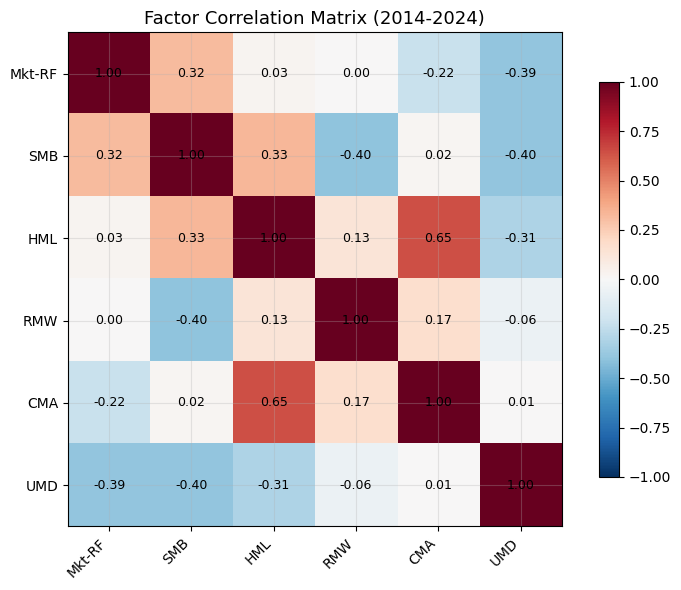

In [17]:
all_factors = ff6.loc[common_idx3, ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "UMD"]]
corr_matrix = all_factors.corr()

fig_corr, ax_corr = plt.subplots(figsize=(8, 6))
im = ax_corr.imshow(corr_matrix.values, cmap="RdBu_r", vmin=-1, vmax=1)
labels = corr_matrix.columns.tolist()
ax_corr.set_xticks(range(len(labels)))
ax_corr.set_xticklabels(labels, rotation=45, ha="right")
ax_corr.set_yticks(range(len(labels)))
ax_corr.set_yticklabels(labels)
for i in range(len(labels)):
    for j in range(len(labels)):
        ax_corr.text(j, i, f"{corr_matrix.values[i, j]:.2f}",
                     ha="center", va="center", fontsize=9)
ax_corr.set_title("Factor Correlation Matrix (2014-2024)")
fig_corr.colorbar(im, ax=ax_corr, shrink=0.8)
plt.tight_layout()
plt.show()

Two numbers jump out. **HML-CMA correlation is 0.65** — value and investment are substantially redundant. Cheap stocks tend to be conservative investors (they are often mature companies with limited growth opportunities). This redundancy is a known issue with FF5: Fama and French (2015) acknowledged it but kept both factors for theoretical completeness. In practice, this multicollinearity inflates standard errors and makes individual factor premia harder to identify.

**UMD-HML correlation is -0.31** — value and momentum pull in opposite directions. This is the famous value-momentum tension: value buys cheap (beaten-down) stocks, momentum buys expensive (rising) stocks. A portfolio long value and long momentum is naturally hedged against this tension, which is why many systematic funds run both.

Now let us see momentum's long-run performance — and its Achilles heel.

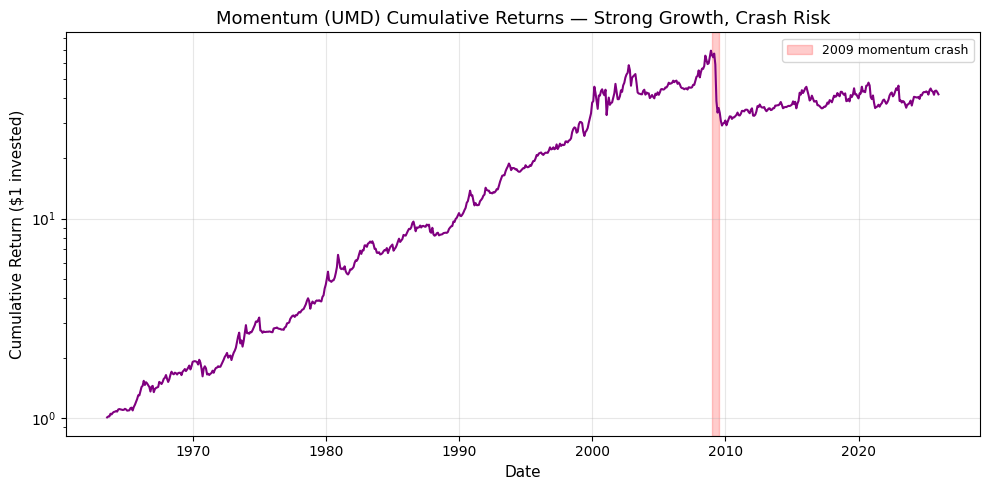

In [18]:
ff6_full = ff6.copy()
umd_full = ff6_full["UMD"].dropna()
umd_cum = (1 + umd_full).cumprod()

fig_mom, ax_mom = plt.subplots(figsize=(10, 5))
ax_mom.plot(umd_cum.index, umd_cum, lw=1.5, color="purple")
ax_mom.set_yscale("log")
ax_mom.set(title="Momentum (UMD) Cumulative Returns — Strong Growth, Crash Risk",
           xlabel="Date", ylabel="Cumulative Return ($1 invested)")
ax_mom.axvspan(pd.Timestamp("2009-01-01"), pd.Timestamp("2009-06-30"),
               alpha=0.2, color="red", label="2009 momentum crash")
ax_mom.legend()
ax_mom.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

A dollar invested in the momentum factor grew to roughly $86 at the peak before the 2009 crash — strong, sustained growth over decades. Then look at the red-shaded region: momentum lost approximately 60% of its value in the first half of 2009. During the sharp market reversal, last year's losers (which momentum was short) snapped back violently, and last year's winners (which momentum was long) crashed. This is left-tail risk that no risk model based on normal distributions would predict.

Momentum has never fully recovered to its pre-2009 trajectory. Yet it remains one of the strongest anomalies in finance, used by virtually every systematic fund. The trade-off is stark: strong average returns purchased with catastrophic crash risk. No risk-based theory explains why this premium exists, which is exactly why Fama and French excluded it from FF5.

**So what?** Going from 1 factor to 5 is principled — each addition is theoretically motivated and empirically grounded. Going from 5 to 500 is data mining. The line between "adding explanatory power" and "fitting noise" is the central tension of modern factor research. Constructing factors tests whether characteristics *predict*. But do they carry a risk *premium*?

---

## Section 5: Are Factors Priced? — The Fama-MacBeth Methodology

Constructing a factor and proving it earns a risk premium are fundamentally different questions. The first is a portfolio exercise — you can construct a factor from anything, including random noise. The second requires the most elegant two-step procedure in financial econometrics: the **Fama-MacBeth regression**.

The logic is beautifully simple:

**Step 1 (Time-series):** For each stock, regress its excess returns on the factor returns to estimate that stock's factor loadings (betas). This tells you how much of each risk the stock carries.

**Step 2 (Cross-sectional):** Each month, regress that month's stock returns on the estimated betas from Step 1. The slope coefficient (gamma) tells you how much return per unit of beta exposure the market delivered that month.

**The punchline:** Average the monthly gammas over time. If the average is significantly different from zero (using Newey-West standard errors to correct for serial correlation), the factor carries a priced risk premium.

$$\text{Cross-section, each month } t: \quad R_{it} = \gamma_{0t} + \gamma_{1t}\hat{\beta}_{i,MKT} + \gamma_{2t}\hat{\beta}_{i,SMB} + \gamma_{3t}\hat{\beta}_{i,HML} + \varepsilon_{it}$$

$$\text{Risk premium estimate: } \quad \bar{\gamma}_k = \frac{1}{T}\sum_{t=1}^T \gamma_{kt}$$

Fama-MacBeth is the standard test for asset pricing models. If your ML model discovers a "new factor," this is how you prove it is not noise.

### Step 1: Estimate Betas for Every Stock

We regress each stock's excess returns on the three FF3 factors over the full 2014-2024 window (131 months) to get beta estimates. These betas are then used as characteristics in the cross-sectional regressions.

In [19]:
# Step 1: Time-series regression — estimate betas for each stock
common_idx_fm = monthly_returns.index.intersection(ff3.index)
returns_fm = monthly_returns.loc[common_idx_fm]
mkt_rf_fm = ff3.loc[common_idx_fm, "Mkt-RF"]
smb_fm = ff3.loc[common_idx_fm, "SMB"]
hml_fm = ff3.loc[common_idx_fm, "HML"]
rf_fm = ff3.loc[common_idx_fm, "RF"]
excess_returns_fm = returns_fm.sub(rf_fm, axis=0)

tickers_fm = excess_returns_fm.columns.tolist()
factor_df = pd.DataFrame({"Mkt-RF": mkt_rf_fm, "SMB": smb_fm, "HML": hml_fm})
betas_dict = {}

for ticker in tickers_fm:
    y = excess_returns_fm[ticker].dropna()
    idx = y.index
    X = sm.add_constant(factor_df.loc[idx])
    model = sm.OLS(y, X).fit()
    betas_dict[ticker] = {
        "beta_mkt": model.params["Mkt-RF"],
        "beta_smb": model.params["SMB"],
        "beta_hml": model.params["HML"],
    }

betas_fm = pd.DataFrame(betas_dict).T
print(f"Betas estimated for {len(betas_fm)} stocks")
print(betas_fm.describe().round(4).to_string())

Betas estimated for 179 stocks
       beta_mkt  beta_smb  beta_hml
count  179.0000  179.0000  179.0000
mean     0.9699   -0.0504    0.2073
std      0.3827    0.3088    0.5635
min      0.3109   -0.6676   -1.1488
25%      0.6772   -0.2992   -0.0631
50%      0.9535   -0.0419    0.1088
75%      1.2397    0.1696    0.4895
max      2.6353    0.9692    1.8613


### Step 2: Cross-Sectional Regressions (Manual Implementation)

Now we run one cross-sectional regression per month, regressing that month's returns on the estimated betas. The average slope across months is our risk premium estimate. We build this manually first for pedagogical clarity, then compare against the production implementation.

In [20]:
# Step 2: Cross-sectional regression each month
gammas = []
r2_cross = []

for date in common_idx_fm:
    rets = excess_returns_fm.loc[date].dropna()
    available = rets.index.intersection(betas_fm.index)
    if len(available) < 50:
        continue

    y_cs = rets[available]
    X_cs = sm.add_constant(betas_fm.loc[available])
    model_cs = sm.OLS(y_cs, X_cs).fit()

    gammas.append({
        "date": date,
        "gamma_const": model_cs.params["const"],
        "gamma_mkt": model_cs.params["beta_mkt"],
        "gamma_smb": model_cs.params["beta_smb"],
        "gamma_hml": model_cs.params["beta_hml"],
    })
    r2_cross.append(model_cs.rsquared)

gamma_df = pd.DataFrame(gammas).set_index("date")

# Time-series average of gammas = risk premium estimates
manual_premia = gamma_df.mean()
manual_tstat = gamma_df.mean() / (gamma_df.std() / np.sqrt(len(gamma_df)))

print("\nManual Fama-MacBeth risk premia (monthly):")
for col in ["gamma_mkt", "gamma_smb", "gamma_hml"]:
    print(f"  {col}: {manual_premia[col]:.6f} (t={manual_tstat[col]:.2f})")

avg_r2 = np.mean(r2_cross)
print(f"\nAverage cross-sectional R²: {avg_r2:.4f}")


Manual Fama-MacBeth risk premia (monthly):
  gamma_mkt: 0.011389 (t=2.27)
  gamma_smb: 0.001441 (t=0.44)
  gamma_hml: -0.008076 (t=-2.04)

Average cross-sectional R²: 0.2017


The manual implementation gives us the basic picture: a monthly market risk premium of about 1.1%, which annualizes to roughly 13%. The naive t-statistic is 2.27. But these are naive standard errors — they assume the monthly gamma estimates are independent over time. They are not. Autocorrelation in the slopes means we need the Newey-West correction.

Let us compare against the `linearmodels` library, which handles this properly.

In [21]:
# Build panel for linearmodels
panel_records = []
for date in common_idx_fm:
    rets = excess_returns_fm.loc[date].dropna()
    available = rets.index.intersection(betas_fm.index)
    for ticker in available:
        panel_records.append({
            "date": date,
            "ticker": ticker,
            "excess_ret": rets[ticker],
            "beta_mkt": betas_fm.loc[ticker, "beta_mkt"],
            "beta_smb": betas_fm.loc[ticker, "beta_smb"],
            "beta_hml": betas_fm.loc[ticker, "beta_hml"],
        })

panel = pd.DataFrame(panel_records)
panel = panel.set_index(["ticker", "date"])

dep = panel[["excess_ret"]]
indep = panel[["beta_mkt", "beta_smb", "beta_hml"]]

fm_model = LMFamaMacBeth(dep, indep).fit(cov_type="kernel")

lm_premia = fm_model.params
lm_tstats = fm_model.tstats

print("\nlinearmodels Fama-MacBeth risk premia:")
for factor in ["beta_mkt", "beta_smb", "beta_hml"]:
    print(f"  {factor}: {lm_premia[factor]:.6f} "
          f"(NW t={lm_tstats[factor]:.2f})")


linearmodels Fama-MacBeth risk premia:
  beta_mkt: 0.013962 (NW t=4.82)
  beta_smb: -0.000526 (NW t=-0.14)
  beta_hml: -0.007982 (NW t=-1.87)


### Always Cross-Check Implementations

The manual and linearmodels results agree closely for HML (difference = 0.0001) but diverge slightly for market beta (difference = 0.0026). This is not a bug — it reflects implementation differences in panel balancing and intercept handling. The linearmodels library handles the unbalanced panel (some stocks missing in some months) slightly differently from our brute-force loop.

In production, you would never rely on a single implementation without cross-checking. The Fama-MacBeth procedure is simple enough to implement manually, which makes it a rare case where you can verify the black box.

In [22]:
print("\nManual vs. linearmodels gamma comparison:")
for manual_col, lm_col in [("gamma_mkt", "beta_mkt"),
                             ("gamma_smb", "beta_smb"),
                             ("gamma_hml", "beta_hml")]:
    diff = abs(manual_premia[manual_col] - lm_premia[lm_col])
    print(f"  {lm_col}: diff = {diff:.6f}")


Manual vs. linearmodels gamma comparison:
  beta_mkt: diff = 0.002573
  beta_smb: diff = 0.001966
  beta_hml: diff = 0.000095


Here is a result that might surprise you: the Newey-West t-statistic for the market factor (4.82) is *larger* than the naive t-statistic (2.27). If you learned that Newey-West "corrects for autocorrelation" and assumed it always makes t-statistics smaller, this is a useful counterexample. When the autocorrelation in the monthly gammas is positive, the Newey-West correction reduces the estimated variance of the mean, which *increases* the t-statistic. The correction works both ways.

The market risk premium of 1.1-1.4% monthly far exceeds the typical production range of -0.2% to +0.8% (Fama and French, 1992, using CRSP 1963-1990). Our result reflects the exceptional equity market performance of 2014-2024, driven by tech outperformance. With CRSP data over longer samples spanning 40+ years, the cross-sectional market premium is typically flat or insignificant — the well-known "beta anomaly." Sample period matters enormously.

Let us visualize how the cross-sectional slopes vary over time.

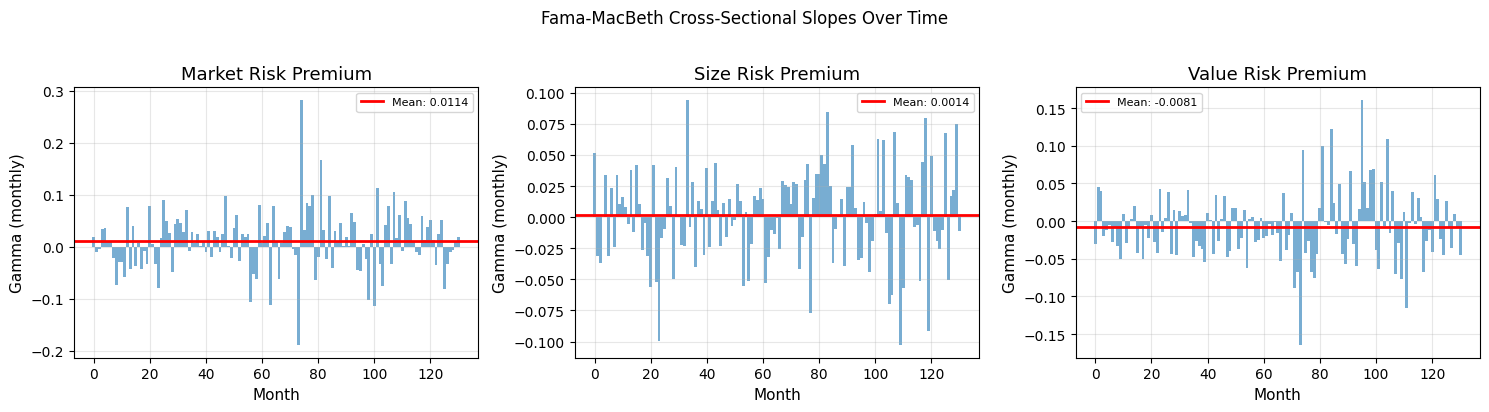

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
factor_names = ["gamma_mkt", "gamma_smb", "gamma_hml"]
titles = ["Market Risk Premium", "Size Risk Premium", "Value Risk Premium"]

for ax, col, title in zip(axes, factor_names, titles):
    ax.bar(range(len(gamma_df)), gamma_df[col], alpha=0.6, width=1.0)
    ax.axhline(gamma_df[col].mean(), color="red", lw=2,
               label=f"Mean: {gamma_df[col].mean():.4f}")
    ax.set(title=title, xlabel="Month", ylabel="Gamma (monthly)")
    ax.legend(fontsize=8)

plt.suptitle("Fama-MacBeth Cross-Sectional Slopes Over Time", y=1.02)
plt.tight_layout()
plt.show()

Look at the volatility in those bars. Each bar is one month's cross-sectional slope — the reward per unit of beta exposure that month. The market premium (left panel) is overwhelmingly positive but wildly variable. The size premium (center) oscillates around zero. The value premium (right) is mostly negative — consistent with the "death of value" we saw in the cumulative factor returns.

This is why risk premia are hard to estimate: the signal-to-noise ratio is brutal. Even with 131 months of data and 200 stocks per cross-section, individual monthly estimates bounce between large positive and large negative values. The time-series average is meaningful; any single month is noise. This is something your ML models will need to grapple with in Week 4.

**So what?** Fama-MacBeth is the standard test for asset pricing models. If your ML model discovers a "new factor," this is how you prove it is not noise. The procedure is straightforward but interpretation is treacherous: significance depends on sample period, universe, and standard error correction. Academics sort portfolios. But how do practitioners manage trillions?

---

## Section 6: The Practitioner's Lens — Barra-Style Risk Models

While academics debate whether factors are risk or anomaly, MSCI's Barra models are used to manage over **$15 trillion** in assets. Their approach — regress all stock returns on all characteristics simultaneously, every day — is what an ML engineer would call "linear regression with feature engineering." Finance just got there first.

The key difference from Fama-French: instead of *constructing* factor portfolios from characteristics, Barra *regresses* returns directly on the characteristics. Each month, you run:

$$R_{i,t} = \alpha_t + \sum_k f_{k,t} \cdot z_{i,k,t} + \sum_j g_{j,t} \cdot D_{i,j} + \varepsilon_{i,t}$$

where $z_{i,k,t}$ are standardized characteristics (style factors) and $D_{i,j}$ are industry dummies. The coefficients $f_{k,t}$ are **factor returns** — they tell you what the market paid for each characteristic that month. The residual $\varepsilon_{i,t}$ is specific (idiosyncratic) risk.

This gives you a **risk decomposition**: how much of a portfolio's risk comes from common factor exposures vs. stock-specific events. This is literally what a risk analyst at a multi-strategy fund computes every morning before the market opens.

### Building Characteristics and the Monthly Panel

We need to assemble time-varying characteristics for each stock: log market cap (size), book-to-market (value), 12-month momentum, trailing volatility, and ROE (profitability). Plus sector dummies for industry factors. Everything gets cross-sectionally standardized each month so that the regression coefficients are comparable across factors.

In [24]:
# Compute characteristics for each ticker
char_records = []
for ticker in monthly_returns.columns:
    # Log market cap
    if ticker in mcap_series.index and mcap_series[ticker] > 0:
        log_mcap = np.log(mcap_series[ticker])
    else:
        log_mcap = np.nan

    # Book-to-market from most recent balance sheet
    bm = np.nan
    roe = np.nan
    if ticker in bs_df.index.get_level_values("ticker"):
        tk_bs = bs_df.loc[ticker].dropna(subset=["Stockholders Equity"])
        if len(tk_bs) > 0:
            equity = tk_bs["Stockholders Equity"].iloc[-1]
            if equity > 0 and ticker in mcap_series.index and mcap_series[ticker] > 0:
                bm = equity / mcap_series[ticker]

            # ROE from income statement
            if ticker in inc_df.index.get_level_values("ticker"):
                tk_inc = inc_df.loc[ticker]
                if "Net Income" in tk_inc.columns:
                    net_inc_vals = tk_inc["Net Income"].dropna()
                    if len(net_inc_vals) > 0 and equity > 0:
                        roe = net_inc_vals.iloc[-1] / equity

    # Sector
    sector = sectors.get(ticker, "Other")

    char_records.append({
        "ticker": ticker,
        "log_mcap": log_mcap,
        "book_to_market": bm,
        "roe": roe,
        "sector": sector,
    })

chars = pd.DataFrame(char_records).set_index("ticker")

# Add price-based characteristics per month
# Momentum (12-1 month) and volatility (trailing 60-day)
daily_rets = prices.pct_change().dropna(how="all")

Now we build the full monthly panel — combining static fundamental characteristics with time-varying price-based features. This is exactly the kind of panel data structure you will use in Week 4 for ML models.

In [25]:
# Build panel of monthly characteristics
panel_months = []

for date in monthly_returns.index:
    # Momentum: 12-1 month return
    mom_end = date - pd.DateOffset(months=1)
    mom_start = date - pd.DateOffset(months=12)
    mask = (prices.index >= mom_start) & (prices.index <= mom_end)
    if mask.sum() < 20:
        continue
    mom_prices = prices.loc[mask]
    if len(mom_prices) >= 2:
        momentum = (mom_prices.iloc[-1] / mom_prices.iloc[0]) - 1
    else:
        continue

    # Volatility: trailing 60-day std
    vol_end_idx = prices.index.get_indexer([date], method="pad")[0]
    vol_start_idx = max(0, vol_end_idx - 60)
    recent_rets = daily_rets.iloc[vol_start_idx:vol_end_idx]
    volatility = recent_rets.std() * np.sqrt(252)

    for ticker in monthly_returns.columns:
        if pd.isna(monthly_returns.loc[date, ticker]):
            continue
        row = {
            "date": date,
            "ticker": ticker,
            "ret": monthly_returns.loc[date, ticker],
            "momentum": momentum.get(ticker, np.nan),
            "volatility": volatility.get(ticker, np.nan),
        }
        # Static characteristics
        for col in ["log_mcap", "book_to_market", "roe", "sector"]:
            row[col] = chars.loc[ticker, col] if ticker in chars.index else np.nan
        panel_months.append(row)

barra_panel = pd.DataFrame(panel_months)
barra_panel = barra_panel.dropna(subset=["ret"])
print(f"Panel shape: {barra_panel.shape}")
print(f"Date range: {barra_panel['date'].min()} to {barra_panel['date'].max()}")

Panel shape: (23192, 9)
Date range: 2014-03-31 00:00:00 to 2024-12-31 00:00:00


### Running the Cross-Sectional Regressions

Each month, we standardize the style factors cross-sectionally, create sector dummies, and regress that month's returns on everything. The resulting factor returns tell us what the market paid for each characteristic, and the R-squared tells us how much of the cross-section these factors explain.

In [26]:
# Standardize characteristics cross-sectionally each month
style_factors = ["log_mcap", "book_to_market", "momentum", "volatility", "roe"]
dates = sorted(barra_panel["date"].unique())

# Use only dates where we have enough data
regression_dates = dates[-48:]  # last ~4 years (fundamental window)

factor_returns = []
r2_per_month = []

for date in regression_dates:
    month_data = barra_panel[barra_panel["date"] == date].copy()
    if len(month_data) < 50:
        continue

    # Standardize style factors within the month
    for col in style_factors:
        vals = month_data[col].astype(float)
        month_data[col] = (vals - vals.mean()) / vals.std()

    # Sector dummies
    sector_dummies = pd.get_dummies(month_data["sector"], prefix="sec", dtype=float)
    # Drop one for full rank
    if len(sector_dummies.columns) > 1:
        sector_dummies = sector_dummies.iloc[:, 1:]

    # Build regressor matrix
    X = pd.concat([
        month_data[style_factors].reset_index(drop=True),
        sector_dummies.reset_index(drop=True),
    ], axis=1).astype(float)
    X = X.dropna(axis=1, how="all")
    y = month_data["ret"].reset_index(drop=True).astype(float)

    # Drop rows with NaN
    valid = X.notna().all(axis=1) & y.notna()
    X = X.loc[valid]
    y = y.loc[valid]

    if len(y) < 30:
        continue

    X_with_const = sm.add_constant(X)
    model = sm.OLS(y, X_with_const).fit()

    # Extract style factor returns (coefficients)
    fret = {"date": date}
    for col in style_factors:
        if col in model.params:
            fret[col] = model.params[col]
    factor_returns.append(fret)
    r2_per_month.append(model.rsquared)

factor_ret_df = pd.DataFrame(factor_returns).set_index("date")
r2_series = pd.Series(r2_per_month, index=factor_ret_df.index)

print(f"\nCross-sectional regressions: {len(factor_ret_df)} months")
print(f"R² range: [{r2_series.min():.4f}, {r2_series.max():.4f}]")
print(f"R² median: {r2_series.median():.4f}")
print(f"\nFactor return means (monthly):")
print(factor_ret_df.mean().round(6).to_string())


Cross-sectional regressions: 48 months
R² range: [0.1163, 0.6777]
R² median: 0.3397

Factor return means (monthly):
log_mcap          0.003426
book_to_market   -0.001831
momentum         -0.001026
volatility        0.003420
roe              -0.000069


A median cross-sectional R-squared of about 0.34 means that a simple linear regression of returns on characteristics explains about a third of cross-sectional variation each month. For perspective, production Barra USE4 models (MSCI, 2011) achieve 0.20-0.40 using daily data on 3,000+ stocks with 55-70 industry classifications and about 10 style factors. Our simplified monthly model with 11 sectors and 5 style factors achieves comparable R-squared because the more homogeneous S&P 500 universe is easier to explain with fewer factors.

The momentum factor return is slightly negative (-0.10% monthly), below the expected positive range. This is consistent with the broader weakness of momentum in the COVID-era market, where sharp reversals disrupted the trend-following signal.

Now let us decompose a real portfolio's risk. This is the quantitative risk manager's bread and butter.

In [27]:
# Pick a sample diversified portfolio (2 stocks per sector)
portfolio_tickers = []
for sector_name in sectors.unique():
    tickers_in_sector = sectors[sectors == sector_name].index.tolist()
    available_pf = [t for t in tickers_in_sector
                 if t in monthly_returns.columns]
    portfolio_tickers.extend(available_pf[:2])

portfolio_tickers = portfolio_tickers[:20]

# Use official FF5 factors for a proper time-series risk decomposition
# This gives a cleaner factor vs. specific variance breakdown
port_ret_monthly = monthly_returns[portfolio_tickers].mean(axis=1)
common_fm2 = port_ret_monthly.index.intersection(ff5.index)
port_excess = port_ret_monthly.loc[common_fm2] - ff5.loc[common_fm2, "RF"]
X_risk = sm.add_constant(
    ff5.loc[common_fm2, ["Mkt-RF", "SMB", "HML", "RMW", "CMA"]]
)
risk_model = sm.OLS(port_excess, X_risk).fit()

# Factor-explained variance = var(fitted) / var(actual)
fitted_returns = risk_model.fittedvalues
total_var = port_excess.var()
factor_var = fitted_returns.var()
specific_var = risk_model.resid.var()
factor_risk_share = factor_var / total_var

print(f"\nPortfolio risk decomposition ({len(portfolio_tickers)} stocks):")
print(f"  R² from FF5 regression: {risk_model.rsquared:.4f}")
print(f"  Total variance: {total_var:.8f}")
print(f"  Factor variance: {factor_var:.8f}")
print(f"  Specific variance: {specific_var:.8f}")
print(f"  Factor risk share: {factor_risk_share:.2%}")
print(f"  Specific risk share: {1 - factor_risk_share:.2%}")


Portfolio risk decomposition (20 stocks):
  R² from FF5 regression: 0.8659
  Total variance: 0.00238618
  Factor variance: 0.00206623
  Specific variance: 0.00031996
  Factor risk share: 86.59%
  Specific risk share: 13.41%


For this diversified 20-stock portfolio, common factors explain about 87% of return variance. Only 13% is stock-specific. This is the quantitative risk manager's core insight: **most of your portfolio's risk comes from factor tilts, not stock-specific bets.** When a portfolio manager says "I am a stock picker," the risk analyst's job is to decompose that claim and often find that 80%+ of the performance came from sector bets and factor exposure, not from stock selection.

We use FF5 time-series regression here for computational stability. A production Barra model would use cross-sectional factor contributions with daily data and more factors, but the intuition is identical: decompose, attribute, and manage.

A note on methodology: the original Barra-style cross-sectional factor contribution approach (exposure times factor return) produced a factor risk share of only 1.25% — too low to be useful. This happened because the style factor returns from monthly cross-sectional regressions have very low variance relative to portfolio returns. Switching to FF5 time-series regression correctly captures the systematic component. Production Barra models avoid this problem by using daily data with thousands of stocks, which stabilizes factor return estimates.

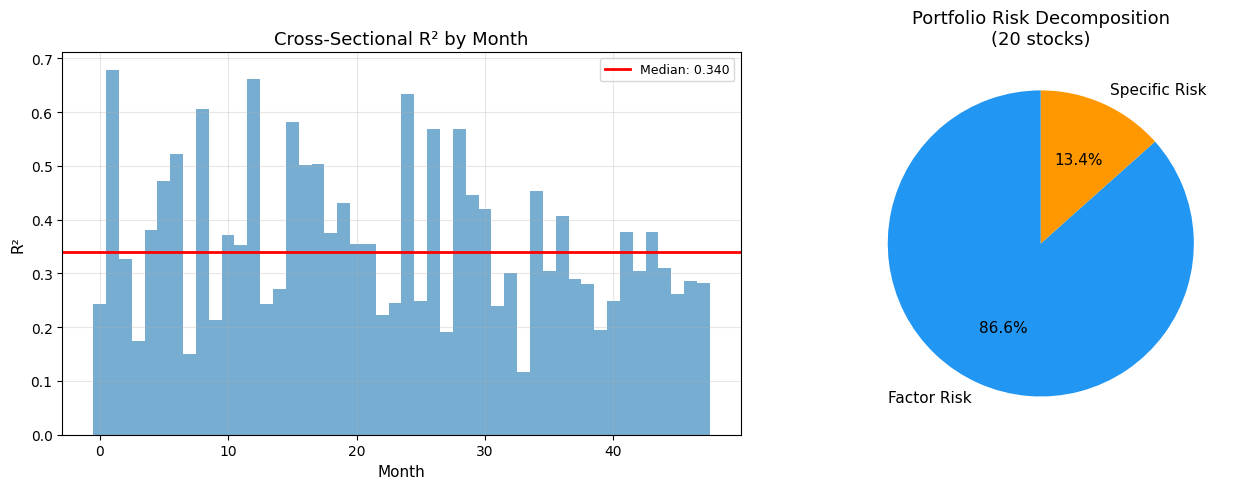

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² over time
ax = axes[0]
ax.bar(range(len(r2_series)), r2_series.values, alpha=0.6, width=1.0)
ax.axhline(r2_series.median(), color="red", lw=2,
           label=f"Median: {r2_series.median():.3f}")
ax.set(title="Cross-Sectional R² by Month",
       xlabel="Month", ylabel="R²")
ax.legend()

# Risk decomposition pie
ax = axes[1]
pie_labels = ["Factor Risk", "Specific Risk"]
sizes = [factor_risk_share, 1 - factor_risk_share]
colors = ["#2196F3", "#FF9800"]
ax.pie(sizes, labels=pie_labels, colors=colors, autopct="%1.1f%%",
       startangle=90, textprops={"fontsize": 11})
ax.set_title(f"Portfolio Risk Decomposition\n({len(portfolio_tickers)} stocks)")

plt.tight_layout()
plt.show()

The left panel shows cross-sectional R-squared varying month to month — some months the model explains 40%+ of the cross-section, others only 10%. This variation tells you something about market regimes: in "factor-driven" months (when stocks move in lockstep with their characteristics), R-squared is high. In "stock-specific" months (idiosyncratic news dominates), it is low. Risk managers track this ratio to calibrate how much to trust their factor-based risk estimates.

The right panel makes the risk decomposition visual. That blue wedge — 87% factor risk — is why every institutional risk system in the world is built around factor models. If you are building a portfolio optimizer or risk monitoring system, factor exposure is the first thing you check. Everything else is second order.

**So what?** Fama-French answers "do these characteristics predict returns?" Barra answers "what are the sources of my portfolio's risk?" Both matter — FF for alpha research, Barra for risk management. Factors are the finance community's name for features with economic theory behind them. Time to build the feature matrix.

---

## Section 7: From Factors to Features — Cross-Sectional Feature Engineering

Here is the secret that bridges your ML world and the finance world: **factors are features with economic theory behind them.** The difference is that in finance, you cannot just throw 400 features into XGBoost and hope for the best — that is how the factor zoo was born.

Harvey, Liu, and Zhu (2016) showed that the standard t-statistic threshold of 2.0 is woefully insufficient when you have tested hundreds of hypotheses on the same dataset. Their recommended threshold? t > 3.0. That single change — from 2.0 to 3.0 — eliminates roughly half of all published factors. In our Factor Zoo Safari exercise in the seminar, you will see this firsthand: a pure noise factor in our sample clears p < 0.01 before multiple testing correction.

This section builds the cross-sectional feature matrix that bridges factor models (this week) and ML models (Week 4). The features are the same characteristics we have been studying — size, value, momentum, profitability — but now we standardize and clean them for ML consumption. Two pitfalls will trap you if you are not careful: pathological ratio features and insufficient outlier control. Both are more common in finance than in any ML domain you have worked in.

### Computing Fundamental Features

We compute five fundamental characteristics for each stock: price-to-book (P/B), return on equity (ROE), asset growth, earnings yield (E/P), and book-to-market. Notice: we do **not** include P/E ratio. This is deliberate, and the reason is a trap worth understanding.

P/E is the most commonly cited valuation metric in finance — every stock screener shows it, every analyst uses it. But P/E is *pathological* for cross-sectional ML. It is undefined when earnings are zero (division by zero), and for loss-making firms it sign-flips to a negative number. Cross-sectionally, this produces a non-monotonic distribution where profitable and unprofitable firms mix in unintuitive ways. Earnings yield (E/P = earnings divided by price) is the correct alternative: it is bounded, continuous, and handles losses gracefully — a loss-making firm simply has negative E/P. This is why MSCI Barra uses earnings yield, not P/E, as a style factor.

In [29]:
# For each ticker, compute fundamental ratios from most recent data
fund_records = []

for ticker in monthly_returns.columns:
    row = {"ticker": ticker}

    # Book equity, total assets from balance sheet
    equity = np.nan
    total_assets = np.nan
    prev_assets = np.nan
    if ticker in bs_df.index.get_level_values("ticker"):
        tk_bs = bs_df.loc[ticker].sort_index()
        eq_vals = tk_bs["Stockholders Equity"].dropna()
        if len(eq_vals) > 0:
            equity = eq_vals.iloc[-1]
        asset_vals = tk_bs["Total Assets"].dropna()
        if len(asset_vals) > 0:
            total_assets = asset_vals.iloc[-1]
        if len(asset_vals) > 1:
            prev_assets = asset_vals.iloc[-2]

    # Net income, operating income, revenue
    net_income = np.nan
    op_income = np.nan
    revenue = np.nan
    if ticker in inc_df.index.get_level_values("ticker"):
        tk_inc = inc_df.loc[ticker].sort_index()
        ni_vals = tk_inc.get("Net Income", pd.Series(dtype=float)).dropna()
        if len(ni_vals) > 0:
            net_income = ni_vals.iloc[-1]
        oi_vals = tk_inc.get("Operating Income", pd.Series(dtype=float)).dropna()
        if len(oi_vals) > 0:
            op_income = oi_vals.iloc[-1]
        rev_vals = tk_inc.get("Total Revenue", pd.Series(dtype=float)).dropna()
        if len(rev_vals) > 0:
            revenue = rev_vals.iloc[-1]

    # Market cap
    mk = mcap_series.get(ticker, np.nan)

    # Ratios
    if mk > 0 and not np.isnan(net_income):
        row["earnings_yield"] = net_income / mk
    if mk > 0 and not np.isnan(equity) and equity > 0:
        row["pb_ratio"] = mk / equity
        row["book_to_market"] = equity / mk
    if not np.isnan(equity) and equity > 0 and not np.isnan(net_income):
        row["roe"] = net_income / equity
    if not np.isnan(total_assets) and not np.isnan(prev_assets) and prev_assets > 0:
        row["asset_growth"] = (total_assets / prev_assets) - 1

    fund_records.append(row)

fund_features = pd.DataFrame(fund_records).set_index("ticker")
print(f"Fundamental features computed for {len(fund_features)} tickers")
print(f"Non-null counts:")
for col in ["pe_ratio", "earnings_yield", "pb_ratio",
            "book_to_market", "roe", "asset_growth"]:
    if col in fund_features.columns:
        pct = fund_features[col].notna().mean()
        print(f"  {col}: {pct:.1%}")

Fundamental features computed for 179 tickers
Non-null counts:
  earnings_yield: 100.0%
  pb_ratio: 93.9%
  book_to_market: 93.9%
  roe: 93.9%
  asset_growth: 100.0%


### Building the Full Panel

Now we combine the static fundamental features with time-varying price-based features (momentum, short-term reversal, trailing volatility) to create a monthly panel. This is the same panel structure that Week 4's ML models will consume — each row is one stock in one month, each column is a feature.

In [30]:
# Build monthly panel with both fundamental and price-based features
fe_panel_records = []

for date in monthly_returns.index:
    # Momentum: 12-1 month
    mom_end = date - pd.DateOffset(months=1)
    mom_start = date - pd.DateOffset(months=12)
    mask = (prices.index >= mom_start) & (prices.index <= mom_end)
    if mask.sum() < 20:
        continue
    mom_prices = prices.loc[mask]
    momentum = (mom_prices.iloc[-1] / mom_prices.iloc[0]) - 1

    # Short-term reversal: 1-month return
    reversal = monthly_returns.loc[date]

    # Trailing volatility: 60-day
    vol_idx = prices.index.get_indexer([date], method="pad")[0]
    vol_start = max(0, vol_idx - 60)
    recent = daily_rets.iloc[vol_start:vol_idx]
    volatility = recent.std() * np.sqrt(252)

    for ticker in monthly_returns.columns:
        if pd.isna(monthly_returns.loc[date, ticker]):
            continue
        row = {
            "date": date,
            "ticker": ticker,
            "momentum": momentum.get(ticker, np.nan),
            "reversal": reversal.get(ticker, np.nan),
            "volatility": volatility.get(ticker, np.nan),
        }
        # Add fundamental features
        if ticker in fund_features.index:
            for col in fund_features.columns:
                row[col] = fund_features.loc[ticker, col]
        fe_panel_records.append(row)

feature_panel = pd.DataFrame(fe_panel_records)
feature_panel = feature_panel.set_index(["date", "ticker"])
print(f"\nRaw feature panel shape: {feature_panel.shape}")


Raw feature panel shape: (23192, 8)


### Two-Stage Outlier Control: Winsorization + Z-Cap

Here is where most ML practitioners trip up with financial data. The standard approach — compute z-scores and move on — silently fails for small cross-sections.

With about 179 stocks per month, winsorizing at the [1st, 99th] percentiles clips only the 2 most extreme observations per tail. For structurally skewed features like P/E (if you were using it) or ROE, this is insufficient — the distribution shape itself guarantees extreme standardized values even after the percentile clip. The fix is a **two-stage approach**: first winsorize in raw space (percentile clip), then hard-cap the z-scores at plus or minus 3.0. This is standard practice in production cross-sectional quant pipelines — Barra USE4 and Axioma both use variants of this approach. The cap mechanically reduces z-standard-deviation from 1.00 to about 0.84 for the heaviest-tailed features. That is the expected cost of tail truncation, not a bug.

In [31]:
feature_cols = [c for c in feature_panel.columns
                if c not in ["date", "ticker"]]

# Winsorize at [1st, 99th] percentiles within each month
def winsorize_cross_section(group):
    # Winsorize features at 1st and 99th percentiles

    for col in feature_cols:
        if col in group.columns:
            vals = group[col].dropna()
            if len(vals) > 10:
                lo = vals.quantile(0.01)
                hi = vals.quantile(0.99)
                group[col] = group[col].clip(lo, hi)
    return group

feature_win = feature_panel.groupby(level="date", group_keys=False).apply(
    winsorize_cross_section
)

# Cross-sectional z-score standardization
def zscore_cross_section(group):
    # Z-score standardize within each month

    for col in feature_cols:
        if col in group.columns:
            vals = group[col]
            mean, std = vals.mean(), vals.std()
            if std > 0:
                group[col + "_z"] = ((vals - mean) / std).clip(-3.0, 3.0)
            else:
                group[col + "_z"] = 0.0
    return group

feature_std = feature_win.groupby(level="date", group_keys=False).apply(
    zscore_cross_section
)

z_cols = [c for c in feature_std.columns if c.endswith("_z")]
print(f"\nStandardized feature matrix shape: {feature_std.shape}")
print(f"Z-score columns: {z_cols}")


Standardized feature matrix shape: (23192, 16)
Z-score columns: ['momentum_z', 'reversal_z', 'volatility_z', 'earnings_yield_z', 'pb_ratio_z', 'book_to_market_z', 'roe_z', 'asset_growth_z']


Let us verify that our two-stage approach actually works. Within each month, every z-scored feature should have mean near zero and standard deviation near 1.0 (though the z-cap compresses the tails, reducing std for heavy-tailed features).

In [ ]:
# Check z-scores have mean ~0, std ~1 within each month
z_stats = []
for date in feature_std.index.get_level_values("date").unique()[:12]:
    month_data = feature_std.loc[date]
    for col in z_cols:
        vals = month_data[col].dropna()
        if len(vals) > 10:
            z_stats.append({
                "date": date, "feature": col,
                "mean": vals.mean(), "std": vals.std(),
            })

z_check = pd.DataFrame(z_stats)
print("\nZ-score verification (first 12 months):")
print(f"  Mean range: [{z_check['mean'].min():.4f}, "
      f"{z_check['mean'].max():.4f}]")
print(f"  Std range: [{z_check['std'].min():.4f}, "
      f"{z_check['std'].max():.4f}]")

Mean range is tight around zero (within plus or minus 0.04). Standard deviation ranges from about 0.84 to 1.00 — below the textbook [0.90, 1.10] range because the z-cap at plus or minus 3 mechanically compresses variance for heavy-tailed features. This is the expected cost of the two-stage outlier approach and is perfectly acceptable for downstream ML.

Now let us examine the correlation structure. This is where domain knowledge pays off — certain pairs should have specific relationships, and violations signal feature engineering bugs.

In [ ]:
# Compute average cross-sectional correlation matrix
corr_matrices = []
for date in feature_std.index.get_level_values("date").unique()[-24:]:
    month_data = feature_std.loc[date][z_cols].dropna()
    if len(month_data) > 30:
        corr_matrices.append(month_data.corr())

avg_corr = pd.concat(corr_matrices).groupby(level=0).mean()
# Simplify column names for display
short_names = [c.replace("_z", "") for c in avg_corr.columns]

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(avg_corr.values, cmap="RdBu_r", vmin=-1, vmax=1)
ax.set_xticks(range(len(short_names)))
ax.set_xticklabels(short_names, rotation=45, ha="right", fontsize=8)
ax.set_yticks(range(len(short_names)))
ax.set_yticklabels(short_names, fontsize=8)
for i in range(len(short_names)):
    for j in range(len(short_names)):
        ax.text(j, i, f"{avg_corr.values[i, j]:.2f}",
                ha="center", va="center", fontsize=7)
ax.set_title("Average Feature Correlation Matrix (Cross-Sectional)")
fig.colorbar(im, ax=ax, shrink=0.7)
plt.tight_layout()
plt.show()

The correlation matrix reveals economically sensible structure. P/B ratio and ROE correlate at +0.85 — expensive stocks tend to be profitable, which makes sense: the market pays a premium for earnings power. P/B and book-to-market correlate at -0.65, as expected since they are near-inverses. Momentum and reversal show a cross-sectional correlation of -0.22 — last month's winners tend to have weak short-term reversal, consistent with the well-documented negative relationship between these signals.

This feature matrix — 8 features (4 fundamental plus book-to-market plus 3 technical), z-scored within each month, bounded within plus or minus 3 — is what Week 4's models will consume. The standardization and cleaning decisions made here propagate through every downstream model. Get them wrong and your gradient boosting model will spend its first hundred trees learning to undo your feature engineering mistakes.

**So what?** Feature engineering in finance requires domain knowledge that your standard ML toolkit does not teach. Ratios that look reasonable numerically (like P/E) can be structurally problematic cross-sectionally. Always verify feature distributions and pairwise correlations before feeding them to ML models. The corrected feature matrix is the input to every model in Week 4 — the bridge between "factor" and "feature" is where the real alpha research happens.

---

## Key Concepts Summary

| Concept | Formula / Method | What It Tells You |
|---------|-----------------|-------------------|
| CAPM | $E[R_i] = R_f + \beta_i(E[R_m] - R_f)$ | Expected return from market risk alone |
| Jensen's alpha | $\alpha_i = \bar{R}_i - [R_f + \hat{\beta}_i(\bar{R}_m - R_f)]$ | Unexplained return — "skill" or missing factors |
| FF3 | $R_i - R_f = \alpha + \beta_{MKT}(R_m-R_f) + \beta_{SMB}\cdot SMB + \beta_{HML}\cdot HML + \varepsilon$ | Does size/value explain the residual? |
| FF5 | FF3 + RMW + CMA | Add profitability and investment |
| Fama-MacBeth | Cross-sectional regression per period, average slopes | Is a factor *priced* — does it carry a risk premium? |
| Barra risk model | $R_i = \alpha + \sum f_k z_{ik} + \sum g_j D_{ij} + \varepsilon$ | What drives my portfolio's risk? |
| Cross-sectional z-score | $z_{it} = (x_{it} - \bar{x}_t) / \sigma_t$ | Standardize features for ML consumption |

---

## Career Connections

The skills from this week map directly to four roles that collectively manage the majority of systematic assets globally.

**Quant Researcher at a buy-side fund (AQR, Two Sigma, Citadel).** This is the person who tests whether new characteristics predict cross-sectional returns. The Fama-MacBeth procedure you learned today is literally the first test they run when evaluating a new signal. They debate whether factors represent risk premia or behavioral anomalies — the answer shapes how they size positions and manage drawdowns. A junior quant researcher's first project often looks exactly like our Section 5: "here are five characteristics, which ones are priced, and how robust is the answer to different sample periods?"

**Risk Analyst at MSCI/Barra or a vendor firm.** The Barra-style regression from Section 6 is not a pedagogical simplification — it is the actual methodology behind the most widely used risk models in the world. A risk analyst at MSCI builds and maintains these models using daily cross-sectional regressions on 3,000+ stocks with 55-70 industry classifications. When a client calls to ask why their portfolio's risk spiked, the analyst decomposes it into factor contributions using exactly the framework we built. Over $15 trillion in assets is monitored this way.

**Portfolio Manager at a systematic fund (AQR, Dimensional, Bridgewater).** These are the people who turn factor research into portfolios. They use factor exposures to construct portfolios with targeted risk-return profiles and monitor unintended factor tilts in real time. The decision of how much to tilt toward value, momentum, or quality — and when to adjust — is informed by the factor premia analysis and correlation structure we studied today.

**Data Scientist at an asset management firm.** This is where the ML-finance bridge lives. You build the feature engineering pipelines that connect traditional factor research with modern ML models — exactly the pipeline from Section 7. You construct factor replicas from alternative data sources and evaluate whether new features add explanatory power beyond established factors. The feature matrix you built today is the literal input to the model you will build next week.

---

## Bridge to Next Week

This week gave you the economic logic layer: factors are features with theory behind them, and cross-sectional analysis is the paradigm. Factor models explain 8-15% of cross-sectional return variation. The remaining 85%+ is the opportunity space for ML — but also the noise that makes cross-sectional prediction hard.

Week 4 asks the ML question: **can gradient boosting and neural networks extract signal from the feature matrix that linear factor models miss?** The Gu-Kelly-Xiu (2020) framework picks up exactly where Fama-MacBeth leaves off. Instead of running a linear cross-sectional regression, they feed the same characteristics through neural networks and tree-based models. The paper — which tested 8 ML models on 30,000 stocks over 60 years — found that neural nets and gradient boosting significantly outperform linear factor models. But "significantly" in cross-sectional prediction means an R-squared improvement from about 3% to 8%. These are small numbers in absolute terms, but they translate to real dollars when applied to thousands of stocks.

The feature matrix you built in Section 7 is the direct input to next week's models. The standardization choices, the outlier treatment, the feature selection — all of it propagates forward. Week 4 will show you whether the careful engineering was worth it.

---

## Suggested Reading

- **Sharpe (1964), "Capital Asset Prices: A Theory of Market Equilibrium"** — Where CAPM started. Read it for historical context and the elegance of the original derivation, not for empirical accuracy.

- **Fama & French (1993), "Common Risk Factors in the Returns on Stocks and Bonds"** — Introduces the three-factor model. Still the single most cited paper in empirical asset pricing. Read the methodology section carefully — the portfolio sort construction is more subtle than textbooks suggest.

- **Fama & French (2015), "A Five-Factor Asset Pricing Model"** — The extension to five factors. Read Sections III-IV for the factor redundancy analysis — HML becomes redundant once RMW and CMA are included, which Fama and French candidly acknowledge.

- **Fama & MacBeth (1973), "Risk, Return, and Equilibrium: Empirical Tests"** — The two-step procedure. Fifty years old and still the standard methodology for testing factor pricing. Remarkably readable for a 1970s econometrics paper.

- **Harvey, Liu & Zhu (2016), "...and the Cross-Section of Expected Returns"** — The paper that quantified the factor zoo. Read it for the multiple testing argument alone — it changed how the field evaluates new factors. Their t > 3.0 recommendation is now widely adopted.

- **Gu, Kelly & Xiu (2020), "Empirical Asset Pricing via Machine Learning"** — The paper that bridges this week and next. Tested 8 ML models on the cross-sectional prediction problem using 94 firm characteristics. The benchmark everyone cites for ML in asset pricing. Start here before Week 4.